In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
import os
import numpy as np
from scipy.linalg import sqrtm
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.stats import entropy
from torch_fidelity import calculate_metrics

In [4]:
output_folder = "../output/diffusion_model/"
pdf_folder = "pdf"
csv_folder = "csv"

In [5]:
generated_images_folder = "diffusion models/generated_images"
generated_images_files_df = pd.read_csv(generated_images_folder + "/generated.csv")
generated_images_files_df

,Image ID,Label,Path
0,pituitary_472,pituitary,diffusion models/generated_images/pituitary_25...
1,pituitary_501,pituitary,diffusion models/generated_images/pituitary_25...
2,pituitary_287,pituitary,diffusion models/generated_images/pituitary_25...
3,pituitary_485,pituitary,diffusion models/generated_images/pituitary_25...
4,pituitary_365,pituitary,diffusion models/generated_images/pituitary_25...
...,...,...,...
2395,meningioma_164,meningioma,diffusion models/generated_images/meningioma_2...
2396,meningioma_85,meningioma,diffusion models/generated_images/meningioma_2...
2397,meningioma_145,meningioma,diffusion models/generated_images/meningioma_2...
2398,meningioma_220,meningioma,diffusion models/generated_images/meningioma_2...


In [13]:
labels = list(generated_images_files_df.Label.unique())
labels

['pituitary', 'glioma', 'notumor', 'meningioma']

### Histogram of 100 random samples per class

In [27]:
def get_histogram(tumor, axes, file_names):
    print
    if len(file_names) > 0:
        sample_size = len(file_names) if len(file_names) < 100 else 100
        plt.yscale('log')
        for file in random.sample(file_names, sample_size):
            image = cv2.imread(file)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            sns.histplot(ax=axes, data=pd.DataFrame(gray.ravel()), x=0).set(title=tumor, xlabel ="Pixel value")
    else:
        axes.set_visible(False)

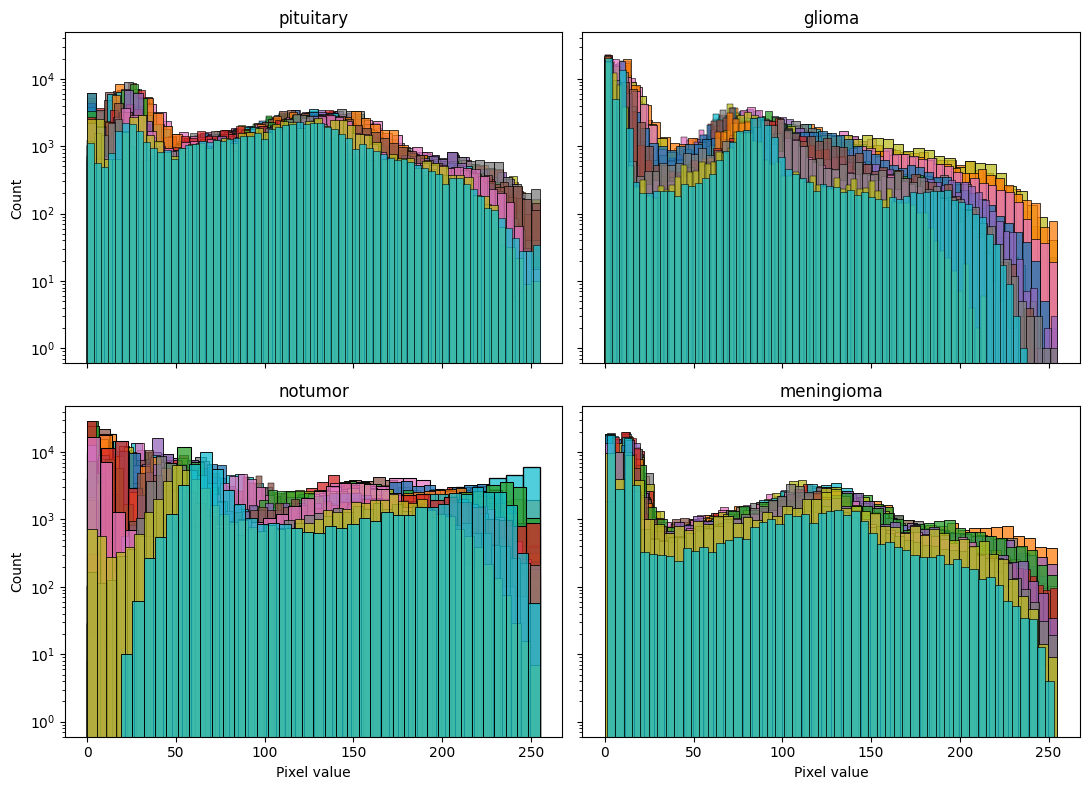

In [33]:
plt.close()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), sharey=True, sharex=True)

label_counter = 0
row_counter = 0
for tumor in labels:
    get_histogram(tumor, axes[row_counter, label_counter], list(generated_images_files_df[generated_images_files_df["Label"] == tumor]["Path"]))
    if label_counter == 1:
        row_counter = 1
        label_counter = 0
    else:
        label_counter += 1
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/generated_images_histogram_tumor_type.pdf")
plt.show()

### Fréchet Inception Distance (FID)

In [ ]:
def load_and_preprocess_images(img_folder, target_size=(299, 299)):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    images = []
    
    for img_file in os.listdir(img_folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(img_folder, img_file)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            images.append(img_array)

    images = np.vstack(images)
    features = model.predict(images)
    return features

In [ ]:
def calculate_fid(act1, act2):
    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

##### The interpretation of Fréchet Inception Distance (FID) scores can be somewhat subjective and highly dependent on the context, such as the complexity of the dataset and the specific application. However, in general, lower FID scores are better, as they indicate closer similarity between the distributions of generated and real images.

0 - 50 (Very good); 50 - 100 (Good enough), 100 - 150: (Moderate), Above 150: (Low)

In [23]:
fid_df = pd.DataFrame(index=["real", "generated"], columns=labels)

,pituitary,glioma,notumor,meningioma
real,45.33,48.28,41.02,58.93
generated,74.88,76.15,80.25,66.42


### `glioma` Fréchet Inception Distance (FID)

Benchmark score (best possible)

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/data_256/Testing/glioma'    # generated
folder_y = '/root/group2/data_256/Training/glioma'   # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["real", "glioma"] = fid_score
print(f'FID score: {fid_score}')

FID of generated images

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/generated_images/glioma_256'   # generated
folder_y = '/root/group2/data_256/Training/glioma'      # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["generated", "glioma"] = fid_score
print(f'FID score: {fid_score}')

### `meningioma` Fréchet Inception Distance (FID)

Benchmark score (best possible)

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/data_256/Testing/meningioma'    # generated
folder_y = '/root/group2/data_256/Training/meningioma'   # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["real", "meningioma"] = fid_score
print(f'FID score: {fid_score}')

FID of generated images

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/generated_images/meningioma_256'   # generated
folder_y = '/root/group2/data_256/Training/meningioma'      # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["generated", "meningioma"] = fid_score
print(f'FID score: {fid_score}')

### `pituitary` Fréchet Inception Distance (FID)

Benchmark score (best possible)

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/data_256/Testing/pituitary'    # generated
folder_y = '/root/group2/data_256/Training/pituitary'   # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["real", "pituitary"] = fid_score
print(f'FID score: {fid_score}')

FID of generated images

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/generated_images/pituitary_256'     # generated
folder_y = '/root/group2/data_256/Training/pituitary'        # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["generated", "pituitary"] = fid_score
print(f'FID score: {fid_score}')

### `notumor` Fréchet Inception Distance (FID)

Benchmark score (best possible)

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/data_256/Testing/notumor'    # generated
folder_y = '/root/group2/data_256/Training/notumor'   # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["real", "notumor"] = fid_score
print(f'FID score: {fid_score}')

FID of generated images

In [ ]:
# Paths to your datasets
folder_x = '/root/group2/generated_images/notumor_256'  # generated
folder_y = '/root/group2/data_256/Training/notumor'     # original

# Load images
images_x = load_and_preprocess_images(folder_x)
images_y = load_and_preprocess_images(folder_y)

# Calculate FID
fid_score = calculate_fid(images_x, images_y)
fid_df.loc["generated", "notumor"] = fid_score
print(f'FID score: {fid_score}')

In [26]:
fid_df = fid_df.astype(float).round(2)
fid_df.to_csv(output_folder + csv_folder + "/fid.csv")
fid_df

,pituitary,glioma,notumor,meningioma
real,45.33,48.28,41.02,58.93
generated,74.88,76.15,80.25,66.42


### Inception Score

In [ ]:
def load_images_from_folder(folder, target_size=(299, 299)):
    images = []
    for img_file in os.listdir(folder):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, img_file)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            images.append(img_array)
    images = np.vstack(images)
    return images

In [ ]:
def calculate_inception_score(images, inception_model):
    preds = inception_model.predict(images)
    marginals = np.mean(preds, axis=0)
    conditional_entropy = np.mean([entropy(preds[i, :], base=2) for i in range(preds.shape[0])])
    marginal_entropy = entropy(marginals, base=2)
    return np.exp(marginal_entropy - conditional_entropy)

In [ ]:
# Load the pretrained Inception model
inception_model = InceptionV3(include_top=True, weights='imagenet')

In [29]:
is_df = pd.DataFrame(index=["real", "generated"], columns=labels)

### `glioma` Inception Score (IS):  real vs generated 

real images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/data_256/Training/glioma'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["real", "glioma"] = is_x
print(f'Inception score (IS) for real glioma images: {is_x}')

generated images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/generated_images/glioma_256'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["generated", "glioma"] = is_x
print(f'Inception score (IS) for generated glioma images: {is_x}')

### `meningioma` Inception Score (IS):  real vs generated 

real images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/data_256/Training/meningioma'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["real", "meningioma"] = is_x
print(f'Inception score (IS) for real meningioma images: {is_x}')

generated images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/generated_images/meningioma_256'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["generated", "meningioma"] = is_x
print(f'Inception score (IS) for generated meningioma images: {is_x}')

### `pituitary` Inception Score (IS):  real vs generated 

real images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/data_256/Training/pituitary'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["real", "pituitary"] = is_x
print(f'Inception score (IS) for real pituitary images: {is_x}')

generated images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/generated_images/pituitary_256'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["generated", "pituitary"] = is_x
print(f'Inception score (IS) for generated pituitary images: {is_x}')

### `notumor` Inception Score (IS):  real vs generated 

real images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/data_256/Training/notumor'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["real", "notumor"] = is_x
print(f'Inception score (IS) for real notumor images: {is_x}')

generated images

In [ ]:
# Load and preprocess images
folder_x = '/root/group2/generated_images/notumor_256'
images_x = load_images_from_folder(folder_x)

# Calculate Inception Scores
is_x = calculate_inception_score(images_x, inception_model)
is_df.loc["generated", "notumor"] = is_x
print(f'Inception score (IS) for generated notumor images: {is_x}')

In [30]:
is_df = is_df.astype(float).round(2)
is_df.to_csv(output_folder + csv_folder + "/is.csv")
is_df

,pituitary,glioma,notumor,meningioma
real,3.07,4.38,3.43,4.24
generated,2.36,3.34,3.26,3.52


### Kernel Inception Distance (KID)

In [34]:
kid_df = pd.DataFrame(index=["avg", "std"], columns=labels)

#### glioma

In [ ]:
generated_images_path = '/root/group2/generated_images/glioma_256'
real_images_path = '/root/group2/data_256/Training/glioma'

kid_score = calculate_metrics(
    input1=generated_images_path, 
    input2=real_images_path,
    isc=False, 
    fid=False, 
    kid=True,
    kid_subset_size=92
)
kid_df.loc["avg", "glioma"] = kid_score["kernel_inception_distance_mean"]
kid_df.loc["std", "glioma"] = kid_score["kernel_inception_distance_std"]
# Print all keys in the returned dictionary
print("Keys in returned dictionary:", kid_score.keys())

#### meningioma

In [ ]:
kid_score = calculate_metrics(
    input1=generated_images_path, 
    input2=real_images_path,
    isc=False, 
    fid=False, 
    kid=True,
    kid_subset_size=92
)
kid_df.loc["avg", "meningioma"] = kid_score["kernel_inception_distance_mean"]
kid_df.loc["std", "meningioma"] = kid_score["kernel_inception_distance_std"]
# Print all keys in the returned dictionary
print("Keys in returned dictionary:", kid_score.keys())

#### pituitary

In [ ]:
generated_images_path = '/root/group2/generated_images/pituitary_256'
real_images_path = '/root/group2/data_256/Training/pituitary'

kid_score = calculate_metrics(
    input1=generated_images_path, 
    input2=real_images_path,
    isc=False, 
    fid=False, 
    kid=True,
    kid_subset_size=92
)
kid_df.loc["avg", "pituitary"] = kid_score["kernel_inception_distance_mean"]
kid_df.loc["std", "pituitary"] = kid_score["kernel_inception_distance_std"]
# Print all keys in the returned dictionary
print("Keys in returned dictionary:", kid_score.keys())

#### notumor

In [ ]:
generated_images_path = '/root/group2/generated_images/notumor_256'
real_images_path = '/root/group2/data_256/Training/notumor'

kid_score = calculate_metrics(
    input1=generated_images_path, 
    input2=real_images_path,
    isc=False, 
    fid=False, 
    kid=True,
    kid_subset_size=92
)
kid_df.loc["avg", "notumor"] = kid_score["kernel_inception_distance_mean"]
kid_df.loc["std", "notumor"] = kid_score["kernel_inception_distance_std"]
# Print all keys in the returned dictionary
print("Keys in returned dictionary:", kid_score.keys())

In [35]:
kid_df = kid_df.astype(float).round(2)
kid_df.to_csv(output_folder + csv_folder + "/kid.csv")
kid_df

,pituitary,glioma,notumor,meningioma
avg,0.07,0.05,0.04,0.04
std,0.01,0.01,0.00,0.00
